## Final Project Submission

Please fill out:
* Student name: Seyma Tas
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Amber Yandow
* Blog post URL:


In [96]:
from sklearn.metrics import recall_score, f1_score, r2_score, roc_auc_score, roc_curve, auc, cohen_kappa_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score
import warnings
import xgboost as xgb
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, ParameterGrid
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style('darkgrid', {'axes.facecolor':'0.9'})

# from sklearn.metrics import plot_confusion_matrix


warnings.filterwarnings('ignore')

In [138]:
df = pd.read_csv('TelcoCustomerChurnData_cleaned_ohe.csv')

In [139]:
df.shape

(7032, 31)

In [3]:
df.head()

tenure  MonthlyCharges  TotalCharges  Churn  gender_Male  SeniorCitizen_1  \
0       1           29.85         29.85      0            0                0   
1      34           56.95       1889.50      0            1                0   
2       2           53.85        108.15      1            1                0   
3      45           42.30       1840.75      0            1                0   
4       2           70.70        151.65      1            0                0   

   Partner_Yes  Dependents_Yes  PhoneService_Yes  \
0            1               0                 0   
1            0               0                 1   
2            0               0                 1   
3            0               0                 0   
4            0               0                 1   

   MultipleLines_No phone service  ...  StreamingTV_No internet service  \
0                               1  ...                                0   
1                               0  ...                                0   
2                               0  ...                                0   
3                               1  ...                                0   
4                               0  ...                                0   

   StreamingTV_Yes  StreamingMovies_No internet service  StreamingMovies_Yes  \
0                0                                    0                    0   
1                0                                    0                    0   
2                0                                    0                    0   
3                0                                    0                    0   
4                0                                    0                    0   

   Contract_One year  Contract_Two year  PaperlessBilling_Yes  \
0                  0                  0                     1   
1                  1                  0                     0   
2                  0                  0                     1   
3                  1                  0                     0   
4                  0                  0                     1   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   

   PaymentMethod_Mailed check  
0                           0  
1                           1  
2                           1  
3                           0  
4                           0  

[5 rows x 31 columns]

# Splitting the data into test and train sets

In [130]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']

In [131]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [136]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5274, 30)
(5274,)
(1758, 30)
(1758,)


In [137]:
print(scaled_X_train.shape)
print(y_train.shape)
print(scaled_X_test.shape)
print(y_test.shape)

(5274, 30)
(5274,)


AttributeError: 'StandardScaler' object has no attribute 'shape'

## Functions to evaluate the model

In [6]:
def roc_curve_and_auc(clf, X_train, X_test, y_train, y_test):

    # Calculate the probability scores of each point in the training set
    y_train_score = clf.fit(X_train, y_train).decision_function(X_train)

    # Calculate the fpr, tpr, and thresholds for the training set
    train_fpr, train_tpr, thresholds = roc_curve(y_train, y_train_score)

    # Calculate the probability scores of each point in the test set
    y_test_score = clf.decision_function(X_test)

    # Calculate the fpr, tpr, and thresholds for the test set
    test_fpr, test_tpr, test_thresholds = roc_curve(y_test, y_test_score)

    # ROC curve for training set
    plt.figure(figsize=(10, 8))
    lw = 2
    plt.plot(train_fpr, train_tpr, color='darkorange',
             lw=lw, label='Train ROC curve')
    plt.plot(test_fpr, test_tpr, color='blue',
             lw=lw, label='Test ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/20.0 for i in range(21)])
    plt.xticks([i/20.0 for i in range(21)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic (ROC) Curve for Training and Testing Sets')
    plt.legend(loc='lower right')
    plt.show()
    # Print the area under the roc curve
    print('Training AUC: {}'.format(round(auc(train_fpr, train_tpr), 5)))
    print('Testing AUC: {}'.format(round(auc(test_fpr, test_tpr), 5)))

In [74]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')



In [7]:
def model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test):

    print('MODEL EVALUATION METRICS:\n',
          '-----------------------------------------------------')
    print('Confusion Matrix for train & test set: \n')
    print(confusion_matrix(y_train, y_pred_train),'\n')
    
    print(confusion_matrix(y_test, y_pred_test))
    
    print('\nRecall for train & test set:\n',
          round(recall_score(y_train, y_pred_train), 4),
          round(recall_score(y_test, y_pred_test), 4))
       
    print('Precision for train & test set:\n', 
          round(precision_score(y_train, y_pred_train), 4),
          round(precision_score(y_test, y_pred_test), 4))

    print('f1 score for train & test set:\n', 
          round(f1_score(y_train, y_pred_train), 4),
          round(f1_score(y_test, y_pred_test), 4))

    print('Accuracy for train and test set:\n ',
          round(accuracy_score(y_train, y_pred_train), 4),
          round(accuracy_score(y_test, y_pred_test), 4))
    
    print("Cohen's Kappa for train and test set:\n ",
    round(cohen_kappa_score(y_train, y_pred_train), 4),
    round(cohen_kappa_score(y_test, y_pred_test), 4))

    print ('roc auc score:\n ', round(roc_auc_score(y_test, y_pred_test),4))

    print('\nClassification Report for train & test set\n',
          '\nTrain set\n',
          classification_report(y_train, y_pred_train),
          '\n\nTest set\n',
          classification_report(y_test, y_pred_test))
    
    print('Mean Cross Validation Score', cross_val_score(clf, X, y, cv=5).mean())   

# Logistic Regression

## Baseline model

In [103]:
clf = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
clf.fit(X_train, y_train)

LogisticRegression(C=1000000000000.0, class_weight=None, dual=False,
                   fit_intercept=False, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [104]:
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [105]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)


MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[3460  403]
 [ 618  793]] 

[[1153  147]
 [ 224  234]]

Recall for train & test set:
 0.562 0.5109
Precision for train & test set:
 0.663 0.6142
f1 score for train & test set:
 0.6084 0.5578
Accuracy for train and test set:
  0.8064 0.789
Cohen's Kappa for train and test set:
  0.4809 0.4207
roc auc score:
  0.6989

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      3863
           1       0.66      0.56      0.61      1411

    accuracy                           0.81      5274
   macro avg       0.76      0.73      0.74      5274
weighted avg       0.80      0.81      0.80      5274
 

Test set
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1300
           1       0.61      0.51      0.56       458



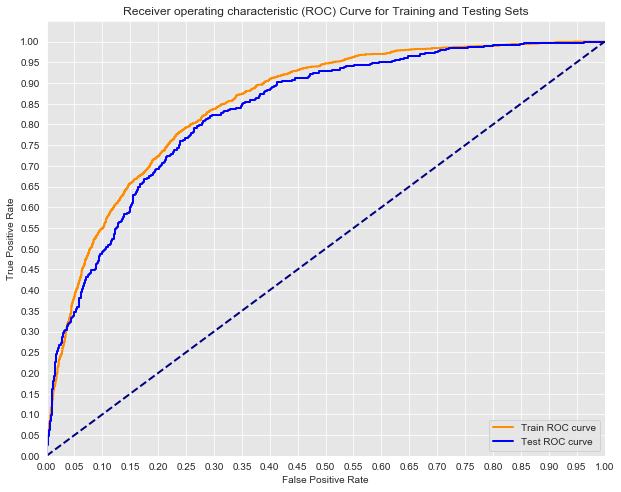

Training AUC: 0.8515
Testing AUC: 0.83351


In [106]:
roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

In [109]:
clf.coef_.round(2)
clf.

array([[-0.06,  0.  ,  0.  , -0.04,  0.24,  0.11, -0.26, -0.54,  0.23,
         0.16,  0.74, -0.1 , -0.1 , -0.48, -0.1 , -0.15, -0.1 , -0.02,
        -0.1 , -0.44, -0.1 ,  0.15, -0.1 ,  0.2 , -0.69, -1.03,  0.22,
        -0.16,  0.21, -0.08]])

# L1 regression

In [125]:
# plot_feature_importances(clf)

# Note: I tried all the other solvers here, 'liblinear' gave the best results.

## Handling Imbalanced Data

## SMOTE

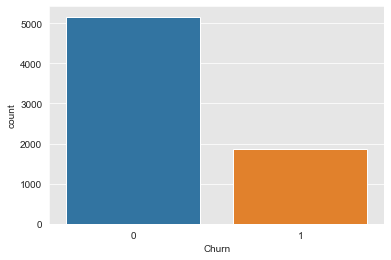

In [12]:
sns.countplot(y);

In [13]:
print(y.value_counts())
print(y.value_counts(normalize=True))

0    5163
1    1869
Name: Churn, dtype: int64
0    0.734215
1    0.265785
Name: Churn, dtype: float64


In [14]:
smote = SMOTE()
X_train_smoted, y_train_smoted = smote.fit_sample(X_train, y_train)

In [15]:
clf = LogisticRegression(fit_intercept=False, C=1e20, solver ='liblinear')
clf.fit(X_train_smoted, y_train_smoted)



LogisticRegression(C=1e+20, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [16]:
y_pred_train = clf.predict(X_train_smoted)
y_pred_test = clf.predict(X_test)

In [17]:
model_evaluation(X_train_smoted, X_test, y_train_smoted, y_test, y_pred_train, y_pred_test)


MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[2873  990]
 [ 726 3137]] 

[[946 354]
 [ 96 362]]

Recall for train & test set:
 0.8121 0.7904
Precision for train & test set:
 0.7601 0.5056
f1 score for train & test set:
 0.7852 0.6167
Accuracy for train and test set:
  0.7779 0.744
Cohen's Kappa for train and test set:
  0.5558 0.4382
roc auc score:
  0.759

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.80      0.74      0.77      3863
           1       0.76      0.81      0.79      3863

    accuracy                           0.78      7726
   macro avg       0.78      0.78      0.78      7726
weighted avg       0.78      0.78      0.78      7726
 

Test set
               precision    recall  f1-score   support

           0       0.91      0.73      0.81      1300
           1       0.51      0.79      0.62       458

   

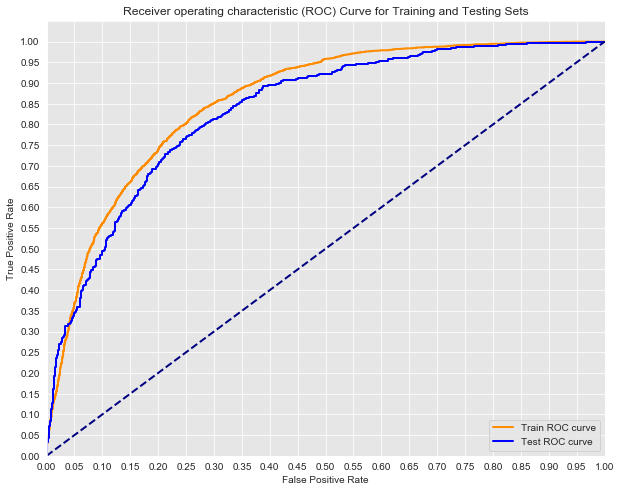

Training AUC: 0.85697
Testing AUC: 0.8349


In [18]:
roc_curve_and_auc(clf,X_train_smoted, X_test, y_train_smoted, y_test)

In [ ]:
clf.feature_importances_

In [ ]:
plot_feature_importances(clf)

## ADASYN

In [19]:
adasyn = ADASYN()

In [20]:
# ADASYN Imbalanced Data


X_train_ada, y_train_ada = adasyn.fit_sample(X_train, y_train)

clf = LogisticRegression(fit_intercept=False, C=1e20, solver ='liblinear')
clf.fit(X_train_ada, y_train_ada)
y_pred_train = clf.predict(X_train_ada)
y_pred_test = clf.predict(X_test)



In [21]:
model_evaluation(X_train_ada, X_test, y_train_ada, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[2725 1138]
 [ 777 3128]] 

[[899 401]
 [ 81 377]]

Recall for train & test set:
 0.801 0.8231
Precision for train & test set:
 0.7332 0.4846
f1 score for train & test set:
 0.7656 0.61
Accuracy for train and test set:
  0.7535 0.7258
Cohen's Kappa for train and test set:
  0.5067 0.4197
roc auc score:
  0.7573

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.78      0.71      0.74      3863
           1       0.73      0.80      0.77      3905

    accuracy                           0.75      7768
   macro avg       0.76      0.75      0.75      7768
weighted avg       0.76      0.75      0.75      7768
 

Test set
               precision    recall  f1-score   support

           0       0.92      0.69      0.79      1300
           1       0.48      0.82      0.61       458

    

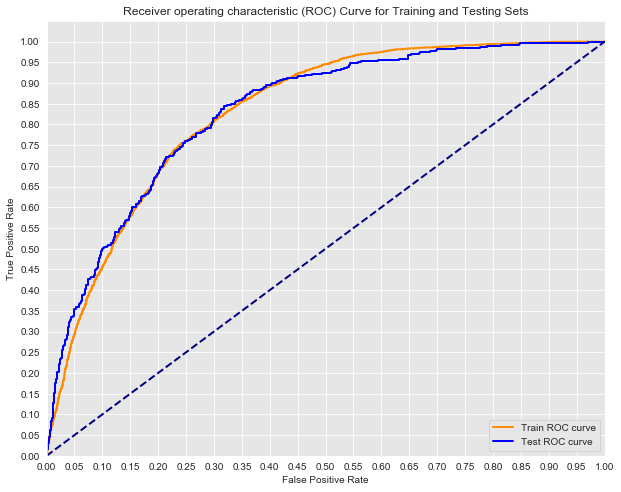

Training AUC: 0.83044
Testing AUC: 0.83087


In [22]:
roc_curve_and_auc(clf, X_train_ada, X_test, y_train_ada, y_test)

In [ ]:
clf.feature_importances_

In [ ]:
plot_feature_importances(clf)

# We can try to solve multicollinearity by interactions
# We can make grid search to find the best hyperparameters

# KNN

In [126]:
scaler = StandardScaler()
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.fit(X_test)
scaled_df_train = pd.DataFrame(scaled_X_train, columns=X_train.columns)

In [127]:
clf = KNeighborsClassifier(n_neighbors=3)
clf.fit(scaled_X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

In [128]:
y_pred_train = clf.predict(scaled_X_train)
y_pred_test = clf.predict(scaled_X_test)

ValueError: Expected 2D array, got scalar array instead:
array=StandardScaler(copy=True, with_mean=True, with_std=True).
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [60]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[3543  320]
 [ 414  997]] 

[[1300    0]
 [ 458    0]]

Recall for train & test set:
 0.7066 0.0
Precision for train & test set:
 0.757 0.0
f1 score for train & test set:
 0.7309 0.0
Accuracy for train and test set:
  0.8608 0.7395
Cohen's Kappa for train and test set:
  0.6372 0.0
roc auc score:
  0.5

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.90      0.92      0.91      3863
           1       0.76      0.71      0.73      1411

    accuracy                           0.86      5274
   macro avg       0.83      0.81      0.82      5274
weighted avg       0.86      0.86      0.86      5274
 

Test set
               precision    recall  f1-score   support

           0       0.74      1.00      0.85      1300
           1       0.00      0.00      0.00       458

    accuracy 

In [61]:
# roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

In [62]:
clf.feature_importances_

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

In [63]:
plot_feature_importances(clf)

AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

<Figure size 576x576 with 0 Axes>

## SMOTE

In [117]:
print(len(scaled_X_train_smoted))
print(len(scaled_X_train))
print(len(X_test))
print(len(scaled_X_train_smoted))

7726
5274


In [118]:
smote = SMOTE()
scaled_X_train_smoted, y_train_smoted = smote.fit_sample(scaled_X_train, y_train)

In [119]:
clf = KNeighborsClassifier(n_neighbors=10)
clf.fit(Scaled_X_train_smoted, y_train_smoted)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='uniform')

In [124]:
np.array(scaled_X_test.reshape(-1, 1))

AttributeError: 'StandardScaler' object has no attribute 'reshape'

In [120]:
y_pred_train = clf.predict(scaled_X_train_smoted)
y_pred_test = clf.predict(scaled_X_test)

ValueError: Expected 2D array, got scalar array instead:
array=StandardScaler(copy=True, with_mean=True, with_std=True).
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [121]:
model_evaluation(scaled_X_train_smoted, scaled_X_test, y_train_smoted, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[2910  953]
 [ 366 3497]] 

[[1300    0]
 [ 458    0]]

Recall for train & test set:
 0.9053 0.0
Precision for train & test set:
 0.7858 0.0
f1 score for train & test set:
 0.8413 0.0
Accuracy for train and test set:
  0.8293 0.7395
Cohen's Kappa for train and test set:
  0.6586 0.0
roc auc score:
  0.5

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.89      0.75      0.82      3863
           1       0.79      0.91      0.84      3863

    accuracy                           0.83      7726
   macro avg       0.84      0.83      0.83      7726
weighted avg       0.84      0.83      0.83      7726
 

Test set
               precision    recall  f1-score   support

           0       0.74      1.00      0.85      1300
           1       0.00      0.00      0.00       458

    accuracy

## ADASYN

In [32]:
adasyn = ADASYN()
X_train_ada, y_train_ada = adasyn.fit_sample(scaled_X_train, y_train)

clf = KNeighborsClassifier()

# Fit the classifier
model = clf.fit(X_train_ada, y_train_ada)
y_pred_train = clf.predict(X_train_ada)
y_pred_test = clf.predict(X_test)

In [33]:
model_evaluation(X_train_ada, X_test, y_train_ada, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[2749 1114]
 [  64 3815]] 

[[1299    1]
 [ 458    0]]

Recall for train & test set:
 0.9835 0.0
Precision for train & test set:
 0.774 0.0
f1 score for train & test set:
 0.8663 0.0
Accuracy for train and test set:
  0.8478 0.7389
Cohen's Kappa for train and test set:
  0.6955 -0.0011
roc auc score:
  0.4996

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.98      0.71      0.82      3863
           1       0.77      0.98      0.87      3879

    accuracy                           0.85      7742
   macro avg       0.88      0.85      0.84      7742
weighted avg       0.88      0.85      0.84      7742
 

Test set
               precision    recall  f1-score   support

           0       0.74      1.00      0.85      1300
           1       0.00      0.00      0.00       458

    ac

# RANDOM FOREST

In [69]:
clf = RandomForestClassifier(random_state=123)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [70]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[3850   13]
 [  84 1327]] 

[[1160  140]
 [ 275  183]]

Recall for train & test set:
 0.9405 0.3996
Precision for train & test set:
 0.9903 0.5666
f1 score for train & test set:
 0.9647 0.4686
Accuracy for train and test set:
  0.9816 0.7639
Cohen's Kappa for train and test set:
  0.9523 0.3227
roc auc score:
  0.6459

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      3863
           1       0.99      0.94      0.96      1411

    accuracy                           0.98      5274
   macro avg       0.98      0.97      0.98      5274
weighted avg       0.98      0.98      0.98      5274
 

Test set
               precision    recall  f1-score   support

           0       0.81      0.89      0.85      1300
           1       0.57      0.40      0.47       45

In [71]:
# roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

AttributeError: 'RandomForestClassifier' object has no attribute 'decision_function'

In [101]:
clf.feature_importances_.round(5)

AttributeError: 'BaggingClassifier' object has no attribute 'feature_importances_'

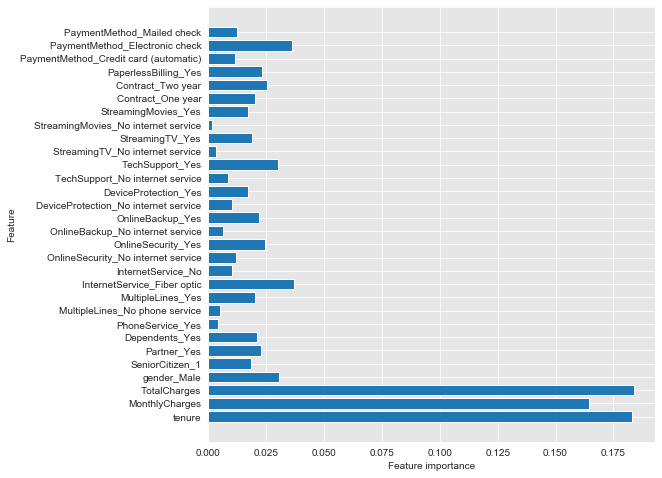

In [75]:
plot_feature_importances(clf)

# Grid search

In [38]:
grid = [{'criterion': ['gini', 'entropy'], 
         'n_estimators':[10, 20, 50, 100, 150, 200],
         'max_depth': [3, 4, 5, 6, 7],
         'min_samples_split': [1.0, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
         'min_samples_leaf': [1,2, 3,4, 5,6,7, 8, 9, 10]}]

In [39]:
#  n_estimators='warn',
# #     criterion='gini',
# #     max_depth=None,
# #     min_samples_split=2,
# #     min_samples_leaf=1,
# #     min_weight_fraction_leaf=0.0,
# #     max_features='auto',
# #     max_leaf_nodes=None,
# #     min_impurity_decrease=0.0,
# #     min_impurity_split=None,
# #     bootstrap=True,
# #     oob_score=False,
# #     n_jobs=None,
# #     random_state=None,
# #     verbose=0,
# #     warm_start=False,
# #     class_weight=None,# 

In [40]:
gridsearch = GridSearchCV(estimator= rfc, param_grid=grid, scoring={
                          'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score)}, cv=5, refit='Accuracy')

In [41]:
rfc.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [42]:
# Fit the training data
gridsearch.fit(X_train, y_train)

# Print the accuracy on test set

gridsearch.score(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
gridsearch.score(X_test, y_test)

In [ ]:
gridsearch.best_params_

In [ ]:
gridsearch.best_score_


# Bagging Classifier

In [97]:
clf = BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=20)

In [98]:
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [99]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[3510  353]
 [ 629  782]] 

[[1171  129]
 [ 227  231]]

Recall for train & test set:
 0.5542 0.5044
Precision for train & test set:
 0.689 0.6417
f1 score for train & test set:
 0.6143 0.5648
Accuracy for train and test set:
  0.8138 0.7975
Cohen's Kappa for train and test set:
  0.4935 0.4353
roc auc score:
  0.7026

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.85      0.91      0.88      3863
           1       0.69      0.55      0.61      1411

    accuracy                           0.81      5274
   macro avg       0.77      0.73      0.75      5274
weighted avg       0.81      0.81      0.81      5274
 

Test set
               precision    recall  f1-score   support

           0       0.84      0.90      0.87      1300
           1       0.64      0.50      0.56       458

In [100]:
roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

AttributeError: 'DecisionTreeClassifier' object has no attribute 'decision_function'

# SVM classifier

In [ ]:
clf = SVC(kernel='linear')
# clf= SVC(kernel='linear', 
#             class_weight='balanced', 
#             probability=True)
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [ ]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

In [ ]:
roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

# Naive Bayes

In [43]:
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [44]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[2305 1558]
 [ 180 1231]] 

[[756 544]
 [ 61 397]]

Recall for train & test set:
 0.8724 0.8668
Precision for train & test set:
 0.4414 0.4219
f1 score for train & test set:
 0.5862 0.5675
Accuracy for train and test set:
  0.6705 0.6559
Cohen's Kappa for train and test set:
  0.3581 0.3342
roc auc score:
  0.7242

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.93      0.60      0.73      3863
           1       0.44      0.87      0.59      1411

    accuracy                           0.67      5274
   macro avg       0.68      0.73      0.66      5274
weighted avg       0.80      0.67      0.69      5274
 

Test set
               precision    recall  f1-score   support

           0       0.93      0.58      0.71      1300
           1       0.42      0.87      0.57       458

 

In [45]:
# roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

In [46]:
clf.feature_importances_

AttributeError: 'GaussianNB' object has no attribute 'feature_importances_'

In [49]:
plot_feature_importances(clf)

NameError: name 'data_train' is not defined

# Xgboost

In [76]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [77]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[3521  342]
 [ 582  829]] 

[[1166  134]
 [ 232  226]]

Recall for train & test set:
 0.5875 0.4934
Precision for train & test set:
 0.7079 0.6278
f1 score for train & test set:
 0.6421 0.5526
Accuracy for train and test set:
  0.8248 0.7918
Cohen's Kappa for train and test set:
  0.5275 0.4194
roc auc score:
  0.6952

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.86      0.91      0.88      3863
           1       0.71      0.59      0.64      1411

    accuracy                           0.82      5274
   macro avg       0.78      0.75      0.76      5274
weighted avg       0.82      0.82      0.82      5274
 

Test set
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1300
           1       0.63      0.49      0.55       45

In [ ]:
# roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

In [94]:
clf.feature_importances_.round(5)

array([0.2 , 0.12, 0.28, 0.  , 0.02, 0.  , 0.02, 0.02, 0.02, 0.02, 0.08,
       0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.02, 0.02, 0.02, 0.  , 0.02,
       0.  , 0.02, 0.02, 0.04, 0.02, 0.  , 0.02, 0.  ])

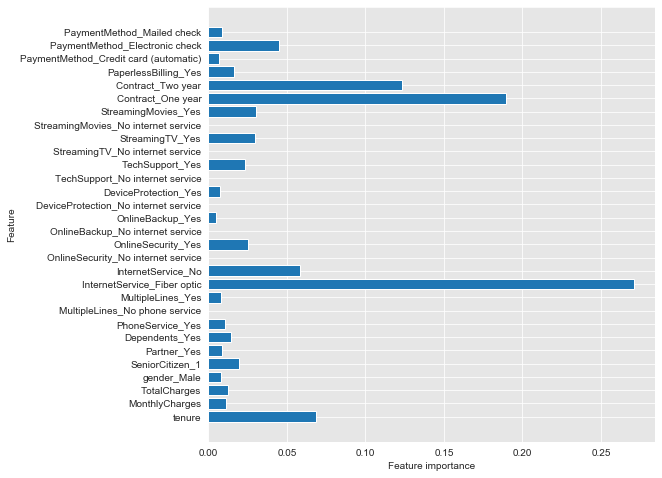

In [79]:
plot_feature_importances(clf)

# Gradient Boosting

In [80]:
clf = GradientBoostingClassifier()
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [81]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[3533  330]
 [ 577  834]] 

[[1165  135]
 [ 231  227]]

Recall for train & test set:
 0.5911 0.4956
Precision for train & test set:
 0.7165 0.6271
f1 score for train & test set:
 0.6478 0.5537
Accuracy for train and test set:
  0.828 0.7918
Cohen's Kappa for train and test set:
  0.5354 0.4203
roc auc score:
  0.6959

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.86      0.91      0.89      3863
           1       0.72      0.59      0.65      1411

    accuracy                           0.83      5274
   macro avg       0.79      0.75      0.77      5274
weighted avg       0.82      0.83      0.82      5274
 

Test set
               precision    recall  f1-score   support

           0       0.83      0.90      0.86      1300
           1       0.63      0.50      0.55       458

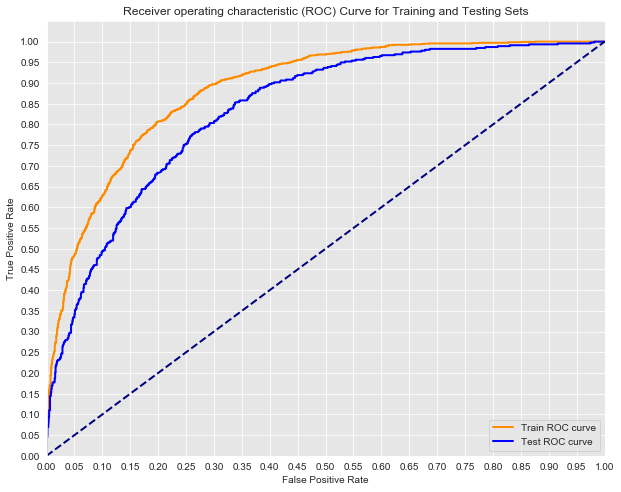

Training AUC: 0.8865
Testing AUC: 0.83414


In [82]:
roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

In [93]:
clf.feature_importances_.round(5)

array([0.2 , 0.12, 0.28, 0.  , 0.02, 0.  , 0.02, 0.02, 0.02, 0.02, 0.08,
       0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.02, 0.02, 0.02, 0.  , 0.02,
       0.  , 0.02, 0.02, 0.04, 0.02, 0.  , 0.02, 0.  ])

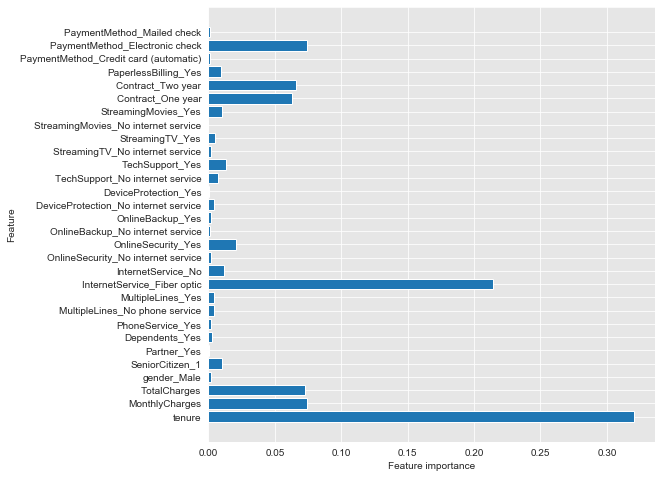

In [84]:
plot_feature_importances(clf)

# Adaboost

In [85]:
clf = AdaBoostClassifier()
clf.fit(X_train, y_train)
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

In [86]:
model_evaluation(X_train, X_test, y_train, y_test, y_pred_train, y_pred_test)

MODEL EVALUATION METRICS:
 -----------------------------------------------------
Confusion Matrix for train & test set: 

[[3476  387]
 [ 607  804]] 

[[1160  140]
 [ 222  236]]

Recall for train & test set:
 0.5698 0.5153
Precision for train & test set:
 0.6751 0.6277
f1 score for train & test set:
 0.618 0.5659
Accuracy for train and test set:
  0.8115 0.7941
Cohen's Kappa for train and test set:
  0.4941 0.4327
roc auc score:
  0.7038

Classification Report for train & test set
 
Train set
               precision    recall  f1-score   support

           0       0.85      0.90      0.87      3863
           1       0.68      0.57      0.62      1411

    accuracy                           0.81      5274
   macro avg       0.76      0.73      0.75      5274
weighted avg       0.80      0.81      0.81      5274
 

Test set
               precision    recall  f1-score   support

           0       0.84      0.89      0.87      1300
           1       0.63      0.52      0.57       458

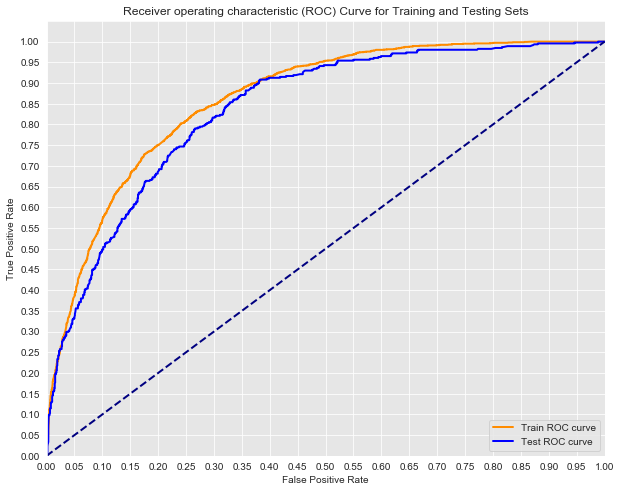

Training AUC: 0.86165
Testing AUC: 0.83645


In [87]:
roc_curve_and_auc(clf, X_train, X_test, y_train, y_test)

In [88]:
clf.feature_importances_

array([0.2 , 0.12, 0.28, 0.  , 0.02, 0.  , 0.02, 0.02, 0.02, 0.02, 0.08,
       0.  , 0.  , 0.02, 0.  , 0.  , 0.  , 0.02, 0.02, 0.02, 0.  , 0.02,
       0.  , 0.02, 0.02, 0.04, 0.02, 0.  , 0.02, 0.  ])

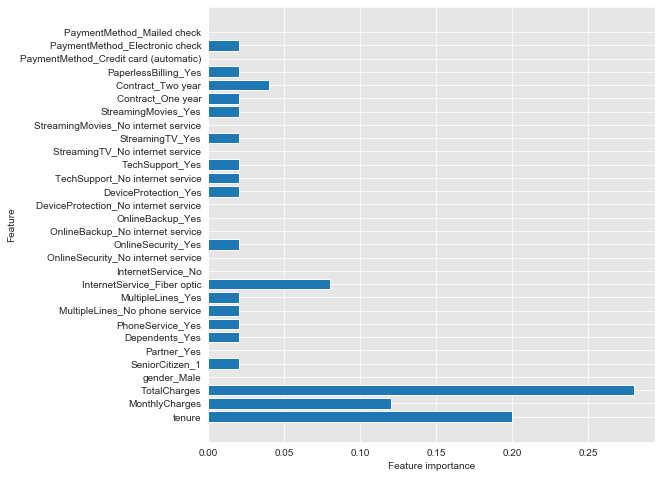

In [89]:
plot_feature_importances(clf)

Feature Importance
Class Weight
Over Under SAmpling
Stratify
Radius Neighbors Classifier
bagging
make_scorer
cohen_kappa_score
Cohen suggested the Kappa result be interpreted as follows: values ≤ 0 as indicating no agreement and 0.01–0.20 as none to slight, 0.21–0.40 as fair, 0.41– 0.60 as moderate, 0.61–0.80 as substantial, and 0.81–1.00 as almost perfect agreement.
simple imputer
n_jobs = -1
Google Colab



In [ ]:
# Plot features importances metric evaluation fonksiyonuna bunu ekleyecegim
imp = pd.Series(data=clf.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=imp.index, x=imp.values, palette="Blues_d", orient='h')